# Progetto Data Intensive 2021

https://www.kaggle.com/divyansh22/flight-delay-prediction

*Andrea Borghesi  -  Matricola 0000874412  -  Anno 2020/2021*

## Introduzione

Il dataset è stato raccolto dal *Bureau of Transportation Statistics of the USA*. <br/>
Il contenuto è diviso in due file *.csv*:

* Jan_2019_ontime.csv : Contiene tutti i voli nel mese di Gennaio 2019. (Pulendo il dataset si ricavano 583985 instanze)
* Jan_2020_ontime.csv : Contiene tutti i voli nel mese di Gennaio 2020.

Le colonne utilizzate in questa analisi sono le seguenti:

* **DAY_OF_MONTH** : Giorno del mese, è un intero da 1 a 31.
* **DAY_OF_WEEK** : Giorno della settimana, è un intero da 1 a 7.
* **ORIGIN** : Sigla aereoporto di origine, è una stringa di lunghezza fissa pari a 3; gli aereoporti di origine sono 346 in totale.
* **DEST** : Sigla areoporto di arrivo; è un parametro analogo a ORIGIN.
* **DEP_TIME** : Orario programmato di partenza; espresso nel formato hhmm.
* **ARR_TIME** : Orario programmato di arrivo; espresso nel formato hhmm.
* **DEP_DEL15** : Indica se l'aereo è partito con 15 o più minuti di ritardo.
* **DISTANCE** : Indica la distanza tra l'aereoporto di partenza e quello di arrivo in miglia.
* **ARR_DEL15** : È la variabile da predire, indica se l'aereo è atterrato con 15 o più minuti di ritardo.


Come primo passo verrà svolta un'analisi dividendo il mese di gennaio in due con il metodo *hold-out* e si cercherà quindi di predire gli aerei in ritardo negli ultimi giorni del mese. <br/>
Per sfruttare la colonna DAY_OF_MONTH è più opportuno testare i modelli ottenuti utilizzando tutto il mese di Gennaio 2019 come training e tutto il mese di Gennaio 2020 come validation set. <br/>
Infine, verrà svolta anche una previsione sul mese di Febbraio 2019 per confrontare il risultato ottenuto con quello ottenuto con la predizione di Gennaio 2020. <br/>

N.B.: la colonna DEP_DEL15 è l'unico parametro che rimane incognito fino al giorno stesso della partenza. Osserveremo come l'accuratezza dei modelli cambia con l'utilizzo o l'esclusione di questo parametro.

## Caricamento dataset e preprocessing dei dati

Importiamo le librerie necessarie.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

<span style="color:red">Disattiviamo i warning solo per una questione estetica.</span>

In [3]:
import warnings
warnings.filterwarnings("ignore")

<br/>
Come preannunciato, svolgiamo inizialmente uno studio sul solo mese di Gennaio 2019.
Salviamo in memoria solo le colonne che ci interessano; così facendo in memoria manteniamo solo 98MB dei 250MB iniziali.

In [4]:
nomi_colonne = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'DEP_TIME', 'ARR_TIME', 'DEP_DEL15', 'DISTANCE', 'ARR_DEL15']

In [5]:
data = pd.read_csv('Jan_2019_ontime.csv')[nomi_colonne]

In [6]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,ARR_TIME,DEP_DEL15,DISTANCE,ARR_DEL15
0,1,2,GNV,ATL,601.0,722.0,0.0,300.0,0.0
1,1,2,MSP,CVG,1359.0,1633.0,0.0,596.0,0.0
2,1,2,DTW,CVG,1215.0,1329.0,0.0,229.0,0.0
3,1,2,TLH,ATL,1521.0,1625.0,0.0,223.0,0.0
4,1,2,ATL,FSM,1847.0,1940.0,0.0,579.0,0.0


In [7]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  583985 non-null  int64  
 1   DAY_OF_WEEK   583985 non-null  int64  
 2   ORIGIN        583985 non-null  object 
 3   DEST          583985 non-null  object 
 4   DEP_TIME      567633 non-null  float64
 5   ARR_TIME      566924 non-null  float64
 6   DEP_DEL15     567630 non-null  float64
 7   DISTANCE      583985 non-null  float64
 8   ARR_DEL15     565963 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 98.0 MB


Per risparmiare altra memoria, possiamo suddividere le colonne in **variabili numeriche** e **variabili categoriche** e ricaricare il dataset salvando in memoria quest'ultimi con *dtype category*.

In [8]:
numeric_vars = ["DEP_TIME", "ARR_TIME", "DISTANCE"]
categorical_vars = ["DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "DEP_DEL15", "ARR_DEL15"]

In [9]:
data = pd.read_csv(
    'Jan_2019_ontime.csv',
    dtype={c: "category" for c in categorical_vars}
)[nomi_colonne]

In [10]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   DAY_OF_MONTH  583985 non-null  category
 1   DAY_OF_WEEK   583985 non-null  category
 2   ORIGIN        583985 non-null  category
 3   DEST          583985 non-null  category
 4   DEP_TIME      567633 non-null  float64 
 5   ARR_TIME      566924 non-null  float64 
 6   DEP_DEL15     567630 non-null  category
 7   DISTANCE      583985 non-null  float64 
 8   ARR_DEL15     565963 non-null  category
dtypes: category(6), float64(3)
memory usage: 17.9 MB


Abbiamo risparmiato circa 70MB e ridotto il peso in memoria di circa l'80%.

Si noti che alcune colonne hanno meno valori non nulli rispetto ad altre. Data la mole di dati in posseso, eliminiamo tutte le righe in cui è presente un valore nullo.

In [11]:
data.dropna(inplace=True)

## Esplorazione dei dati

Analizziamo la correlazione tra aeroporto di origine/destinazione con il numero di aerei in ritardo.

<AxesSubplot:>

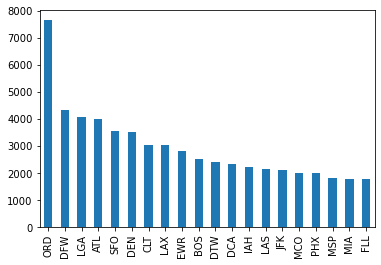

In [12]:
data['ORIGIN'][data['ARR_DEL15'] == "1.00"].value_counts().head(20).plot.bar()

<AxesSubplot:>

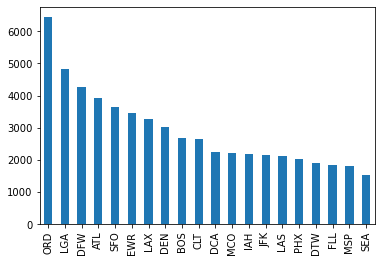

In [13]:
data['DEST'][data['ARR_DEL15'] == "1.00"].value_counts().head(20).plot.bar()

L'aeroporto che conta più ritardi è l'Aeroporto Internazionale di Chicago, sia per partenza che per arrivi.

Osserviamo a livello di percentuale se la situazione cambia.

<AxesSubplot:>

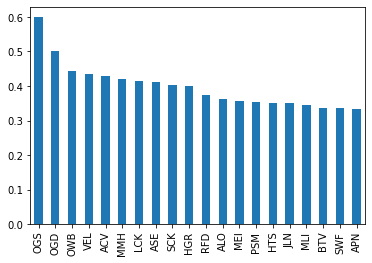

In [14]:
(data['ORIGIN'][data['ARR_DEL15'] == "1.00"].value_counts().sort_index() \
/ data['ORIGIN'].value_counts().sort_index()).sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot:>

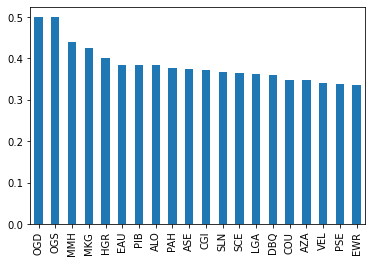

In [15]:
(data['DEST'][data['ARR_DEL15'] == "1.00"].value_counts().sort_index() \
/ data['DEST'].value_counts().sort_index()).sort_values(ascending=False).head(20).plot.bar()

OGD è l'Aeroporto regionale dello Utah, se si parte o atterra in esso si arriva in ritardo nel 50% dei casi!

Discorso analogo per l'Aeroportodi New York (OGS).

<AxesSubplot:xlabel='DISTANCE', ylabel='ARR_DEL15'>

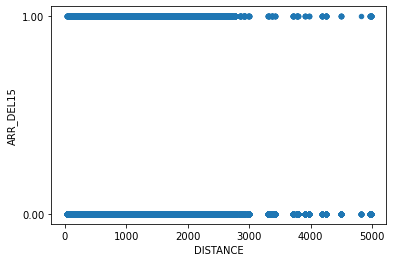

In [16]:
data.plot.scatter('DISTANCE', 'ARR_DEL15')

Da questo grafico si può intuire che la distanza non influenza molto i ritardi degli aerei.

<AxesSubplot:>

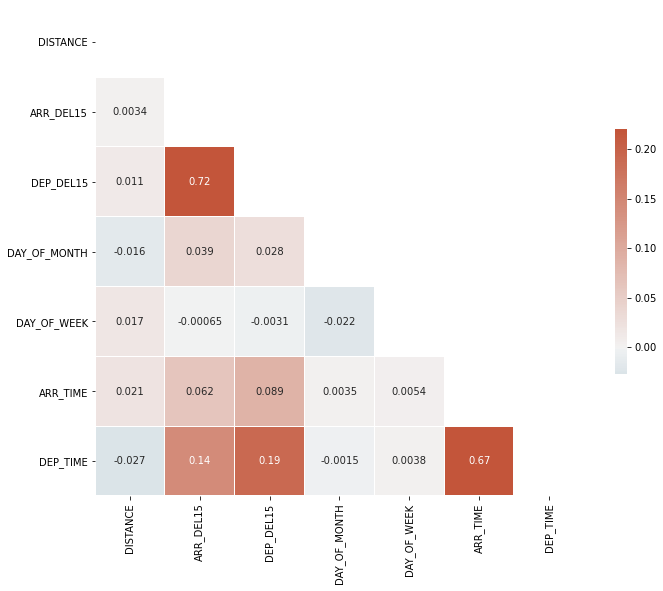

In [17]:
data_expl = data[['DISTANCE']]
data_expl['ARR_DEL15'] = data['ARR_DEL15'].astype('float32')
data_expl['DEP_DEL15'] = data['DEP_DEL15'].astype('float32')
data_expl['DAY_OF_MONTH'] = data['DAY_OF_MONTH'].astype('int8')
data_expl['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].astype('int8')
data_expl['ARR_TIME'] = data['ARR_TIME'].astype('int16')
data_expl['DEP_TIME'] = data['DEP_TIME'].astype('int16')


corr = data_expl.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.22, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A conferma di quanto detto sopra, notiamo la bassa correlazione tra la distanza e il ritardo degli aerei. Al contrario, notiamo come la variabile ARR_DEL15 e DEP_DEL15 siano correlate. 

## Previsione con parametro DEP_DEL15

Studiamo meglio la variabile DEP_DEL15 e la sua relazione con la variabile da prevedere ARR_DEL15. <br/>
Una forte correlazione tra queste due variabili era prevedibile dato che un aereo che parte in ritardo è probabile che arrivi in ritardo.

In [18]:
dep_del = data['DEP_DEL15']
arr_del = data['ARR_DEL15']

In [19]:
pd.DataFrame([dep_del.value_counts(), arr_del.value_counts()])['1.00']

DEP_DEL15     98305
ARR_DEL15    105222
Name: 1.00, dtype: int64

Osserviamo che circa 98 mila aerei sono partiti in ritardo e circa 105 mila aerei sono atterratti in ritardo. <br/>
Calcoliamo ora quante volte i due eventi si verificano nello stesso volo.

In [20]:
arr_del.iloc[np.where(dep_del == "1.00")].value_counts()

1.00    78288
0.00    20017
Name: ARR_DEL15, dtype: int64

Notiamo che circa il 79% delle volte che un aereo parte in ritardo, arriva anche in ritardo. <br/>

Addestriamo un modello utilizzando solo questa variabile.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(dep_del), pd.DataFrame(arr_del), test_size=0.15, random_state=42, shuffle=False)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9166617586430297

In [22]:
cm = confusion_matrix(y_val, model.predict(X_val))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,66049,3137
1.00,3938,11771


Si ottiene un ottimo risultato!  <br/>
Ovviamente questa previsione è possibile farla solo qualche istante prima della partenza dell'aereo.
D'ora in avanti procediamo senza tale parametro per vedere se il ritardo di un aereo è prevedibile anche nei giorni precedenti alla partenza.

## Divisione dataset 

Dividiamo il dataset nelle colonne per il training e in quella da predire.

In [23]:
X = data.drop(columns=['ARR_DEL15', 'DEP_DEL15'])

In [24]:
y = data[['ARR_DEL15']]

## Gestione variabili categoriche

Le colonne ORIGIN e DEST contengono gli acronimi di 346 aereoporti. <br/>
Per potere addestrare i modelli di classificazione convertiremo le variabili categoriche in binarie con il filtro *OneHotEncoder*.

In [25]:
string_vars = ['ORIGIN', 'DEST']

In [26]:
encoder = OneHotEncoder(sparse=False)

In [27]:
encoder.fit_transform(X[['ORIGIN']])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
pd.DataFrame(
    encoder.transform(X[['ORIGIN']]),
    columns=encoder.get_feature_names(['ORIGIN'])
).head(5)

,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACT,ORIGIN_ACV,ORIGIN_ACY,ORIGIN_ADK,ORIGIN_ADQ,...,ORIGIN_TYS,ORIGIN_UIN,ORIGIN_USA,ORIGIN_VEL,ORIGIN_VLD,ORIGIN_VPS,ORIGIN_WRG,ORIGIN_XNA,ORIGIN_YAK,ORIGIN_YUM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# memorizziamo il nome di tutte le colonne in un array per utilizzi futuri
nomi_colonne = [c for c in X.columns if c not in string_vars]+ \
               list(encoder.get_feature_names(['ORIGIN'])) + list(encoder.get_feature_names(['DEST'])) 
len(nomi_colonne)

697

Ovviamente questo filtro genererà 697 colonne e prolungherà il tempo necessario per l'addestramento e la validazione: bisognerà considerare se mantenere tali colonne o eliminarle del tutto.

Creiamo un'istanza della classe ColumnTrasformer che applicheremo nelle varie Pipeline dei modelli successivi. In questo modo applicheremo la **standardizzazione** sulle variabili numeriche e il filtro **OneHotEncoding** sulle variabili categoriche.

In [30]:
preprocessor = ColumnTransformer([
    ("numeric"    , StandardScaler(), [c for c in X.columns if c not in string_vars]),
    ("categorical", encoder , string_vars)
])

## Previsione

Dividiamo il dataset in training set e validation set senza effettuare lo shuffle. Con il metodo **hold-out** e un test_size del 15% si cerca di predire il ritardo degli aerei dal 27 al 31 Gennaio.

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)

In [32]:
X_val.head(1)

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,ARR_TIME,DISTANCE
492234,27,7,MSY,CLE,958.0,1305.0,917.0


Si osservi che negli ultimi giorni del mese solo il 18.5% degli aerei arriva in ritardo. La percentuale rimane costante anche nella parte precedente del mese.

In [33]:
y_val.value_counts()

ARR_DEL15
0.00         69186
1.00         15709
dtype: int64

<AxesSubplot:xlabel='ARR_DEL15'>

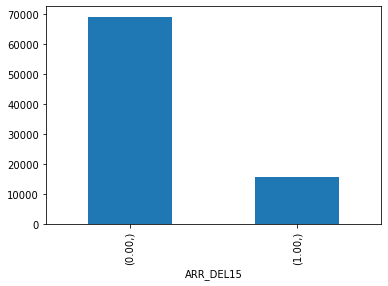

In [34]:
y_val.value_counts().plot.bar()

Le classi sono abbastanza sbilanciate: nel validation set solo circa il 20% degli aerei arriva in ritardo.

Per ora proviamo a mantenere il dataset intatto, mentre in seguito rieffettueremo i test bilanciando le due classi.

### • PERCEPTRON

In [35]:
model = Pipeline([
    ('preproc', 
        ColumnTransformer([
            ("categorical", encoder , string_vars)
        ])
    ),
    ('regr', Perceptron(random_state=42))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7496790152541375

In [36]:
cm = confusion_matrix(y_val, model.predict(X_val))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,61571,7615
1.00,13636,2073


Osserviamo una buona predizione dei voli in orario, ma un risultato non buono per i voli in ritardo.

### • REGRESSIONE LOGISTICA 

In [37]:
%%time
from sklearn.linear_model import LogisticRegression
model = Pipeline([
    ('preproc', preprocessor),
    ('regr', LogisticRegression(solver="saga", random_state=42, C=1, penalty='l1'))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 4min 51s, sys: 2.9 s, total: 4min 54s
Wall time: 4min 54s


0.813840626656458

In [38]:
pd.Series(model.named_steps['regr'].coef_[0], index=nomi_colonne)

DAY_OF_MONTH    0.154205
DAY_OF_WEEK    -0.026156
DEP_TIME        0.470329
ARR_TIME       -0.098567
DISTANCE       -0.015847
                  ...   
DEST_VPS        0.155319
DEST_WRG        0.419075
DEST_XNA       -0.103465
DEST_YAK        0.174062
DEST_YUM       -0.008281
Length: 697, dtype: float64

Notiamo un aumento della precisione rispetto al Perceptron a fronte di un tempo di addestramento più oneroso. <br/>

### • DECISION TREE 

In [39]:
%%time
model = Pipeline([
    ("preproc", preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 12.2 s, sys: 2.41 s, total: 14.7 s
Wall time: 15.1 s


0.8179869250250309

In [40]:
coef = pd.Series(model.named_steps['tree'].feature_importances_, index=nomi_colonne)
coef

DAY_OF_MONTH    0.165354
DAY_OF_WEEK     0.030913
DEP_TIME        0.021905
ARR_TIME        0.592763
DISTANCE        0.008549
                  ...   
DEST_VPS        0.000000
DEST_WRG        0.000000
DEST_XNA        0.000000
DEST_YAK        0.000000
DEST_YUM        0.000000
Length: 697, dtype: float64

In [41]:
coef[coef > 0.01]

DAY_OF_MONTH    0.165354
DAY_OF_WEEK     0.030913
DEP_TIME        0.021905
ARR_TIME        0.592763
ORIGIN_ORD      0.053892
DEST_LGA        0.086716
DEST_SFO        0.015401
DEST_SJU        0.012410
dtype: float64

L'albero ha ottenuto lo stesso risultato della regressione logistica in soli 18 secondi.

## Previsione mese di Gennaio 2020

Proviamo ad addestrare un modello che utilizzi un *albero decisionale* su tutto il mese di Gennaio 2019 ed effettuare una validazione su tutto il mese di Gennaio 2020.

Abbiamo già pronte le istanze di training.

In [42]:
X_2019, y_2019 = X, y

In [43]:
data_2020 = pd.read_csv(
    'Jan_2020_ontime.csv',
    dtype={c: "category" for c in categorical_vars}
)[list(X_2019.columns) + ['ARR_DEL15']]

data_2020.dropna(inplace=True)

X_2020 = data_2020.drop(columns=['ARR_DEL15'])
y_2020 = data_2020[['ARR_DEL15']]

Controlliamo se nel 2020 sono state aggiunti dei voli da aereoporti che non erano stati utilizzati nel 2019. <br/>

In [44]:
new_origin = [k for k in X_2020['ORIGIN'].unique() if k not in data['ORIGIN'].unique()]
        
pd.Series(new_origin)

0    XWA
1    ATY
2    PIR
3    PAE
4    BFM
5    SHR
6    RIW
dtype: object

In [45]:
old_origin = data['ORIGIN'].unique()
new_origin_index = [k for k in X_2020['ORIGIN'].index if data_2020['ORIGIN'][k] not in old_origin]
len(new_origin_index)

427

In [46]:
new_dest_index = [k for k in X_2020['DEST'].index if data_2020['DEST'][k] not in old_origin]
len(new_dest_index)

425

Dato che questi nuove destinazioni compaiono in solo 427+425 voli, possiamo ignorarli per la nostra analisi.

In [47]:
X_2020 = X_2020.drop(new_origin_index+new_dest_index).reset_index().drop(columns=['index'])
y_2020 = y_2020.drop(new_origin_index+new_dest_index).reset_index().drop(columns=['index'])

Procediamo con l'addestramento e la previsione.

In [48]:
model = Pipeline([
    ("preproc", preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=3, min_samples_split=1000, random_state=42))
])
model.fit(X_2019, y_2019)
model.score(X_2020, y_2020)

0.8648985552774315

L'accuratezza è aumentata per il mese di Gennaio 2020.

In [49]:
cm = confusion_matrix(y_2020, model.predict(X_2020))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,514105,2243
1.00,78609,3497


Notiamo però un notevole sbilanciamento tra le due classi previste. Nella prossima sezione verrà effettuato un tentativo di previsione bilanciando le due classi.

In [50]:
coef = pd.Series(model.named_steps['tree'].feature_importances_, index=nomi_colonne)
coef[coef > 0.001]

DEP_TIME    0.009883
ARR_TIME    0.903881
DEST_LGA    0.067858
DEST_SJU    0.018378
dtype: float64

Notiamo che il parametro più rilevante è l'orario di atterraggio. 

Inoltre, anche l'aereoporto LaGuardia di New York, leggendo la rappresentazione sottostante, si può notare che è associato alla classe 0.

In [51]:
from sklearn.tree import export_text
print(export_text(model.named_steps['tree'], feature_names=nomi_colonne))

|--- ARR_TIME <= -2.15
|   |--- ARR_TIME <= -2.75
|   |   |--- DEP_TIME <= 1.85
|   |   |   |--- class: 0.00
|   |   |--- DEP_TIME >  1.85
|   |   |   |--- class: 1.00
|   |--- ARR_TIME >  -2.75
|   |   |--- DEST_SJU <= 0.50
|   |   |   |--- class: 1.00
|   |   |--- DEST_SJU >  0.50
|   |   |   |--- class: 0.00
|--- ARR_TIME >  -2.15
|   |--- ARR_TIME <= 0.42
|   |   |--- ARR_TIME <= -0.88
|   |   |   |--- class: 0.00
|   |   |--- ARR_TIME >  -0.88
|   |   |   |--- class: 0.00
|   |--- ARR_TIME >  0.42
|   |   |--- DEST_LGA <= 0.50
|   |   |   |--- class: 0.00
|   |   |--- DEST_LGA >  0.50
|   |   |   |--- class: 0.00



La colonna ARR_TIME è visibilmente la più influente: se abbassiamo l'altezza massima dell'albero, essa sarà l'unica variabile utilizzata dall'albero.

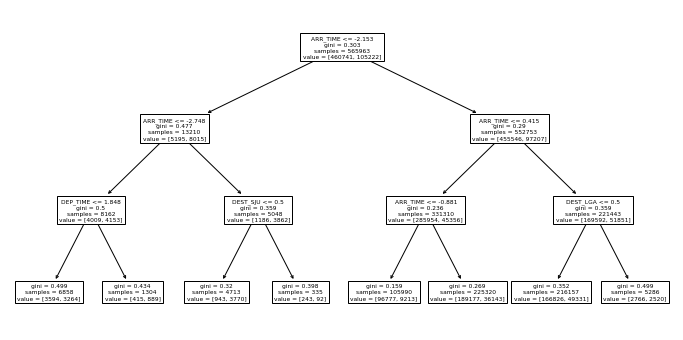

In [52]:
plt.figure(figsize=(12, 6))
plot_tree(model.named_steps['tree'], feature_names=nomi_colonne);

## Bilanciamento classi

Dato che (per fortuna) gli aerei che arrivano in orario sono in numero maggiore rispetto a quelli che arrivano in ritardo di più di 15 minuti (nel gennaio 2020 solo il 13.7% è arrivato in ritardo), proviamo a bilancere le due classi per osservare se otteniamo risultati migliori. Tale sbilanciamento ha portato a una classificazione molto poco accurata per quanto riguarda gli aerei in ritardo.

Riaddestriamo i modelli usati fino ad ora definendo però questa volta l'iperparametro **class_weight**, il quale permette di associare un peso differente alle due classi con lo scopo di renderle bilanciate.

In [53]:
model = Pipeline([
    ("preproc", preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=20, min_samples_split=1000, class_weight='balanced', random_state=42))
])
model.fit(X_2019, y_2019)
model.score(X_2020, y_2020)

0.6251892376022217

In [54]:
cm = confusion_matrix(y_2020, model.predict(X_2020))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,333375,182973
1.00,41334,40772


In [55]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.65
Aerei correttamente classificati in ritardo:  0.50


Notiamo un peggioramento della previsione degli aerei in orario, ma un aumento notevole della previsione degli aerei in ritardo grazie al bilanciamento delle classi.

Proviamo con la *regressione logistica*.

In [56]:
%%time
model = Pipeline([
    ('preproc', preprocessor),
    ('regr', LogisticRegression(solver="saga", random_state=42, C=0.1, penalty='l1', class_weight='balanced'))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 1min 8s, sys: 1.74 s, total: 1min 10s
Wall time: 1min 9s


0.5105718829141881

In [57]:
cm = confusion_matrix(y_2020, model.predict(X_2020))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,302420,213928
1.00,38005,44101


In [58]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.59
Aerei correttamente classificati in ritardo:  0.54


Proviamo anche attraverso una **GridsSearchCV** quale sia il valore dell'iperparametro *class_weight* migliore.

In [59]:
kf = KFold(3, shuffle=False)
model = Pipeline([
    ('preproc', preprocessor),
    ('regr', DecisionTreeClassifier(min_samples_split=100, random_state=42))
])
grid = {
    'regr__class_weight': ['balanced', {'1.00': 2, '0.00': 1}, {'1.00': 3, '0.00': 1}],
    'regr__max_depth': [50]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_2019, y_2019)
gs.score(X_2020, y_2020)

0.7599932492722916

In [60]:
gs.best_params_

{'regr__class_weight': {'1.00': 2, '0.00': 1}, 'regr__max_depth': 50}

Come era prevedibile, la GridSearch individua come stimatore migliore il modello meno bilanciato, dato che ottiene uno score maggiore.

Proviamo anche con un'altra tecnica denominata **SMOTE**: consiste nel creare delle istanze fittizie della classe meno rappresentata per bilanciarla rispetto all'altra classe più rappresentata.

Per prima cosa prepariamo il dataset, per semplicità questa volta ignoreremo le colonne ORIGIN e DEST.

In [61]:
X_smote = X_2019.drop(columns=['ORIGIN', 'DEST'])

X_smote['DAY_OF_MONTH'] = X_2019['DAY_OF_MONTH'].astype('int16')
X_smote['DAY_OF_WEEK'] = X_2019['DAY_OF_WEEK'].astype('int16')

X_smote.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE
0,1,2,601.0,722.0,300.0
1,1,2,1359.0,1633.0,596.0
2,1,2,1215.0,1329.0,229.0
3,1,2,1521.0,1625.0,223.0
4,1,2,1847.0,1940.0,579.0


In [62]:
from imblearn.over_sampling import SMOTE

balancer = SMOTE(random_state=42, 
                 sampling_strategy=0.8  # rapporto numero istanze tra le due classi dopo il bilanciamento
           )

In [63]:
X_train_smote = pd.DataFrame(balancer.fit_resample(X_smote, y_2019['ARR_DEL15'])[0])

In [64]:
y_train_smote = pd.DataFrame(balancer.fit_resample(X_smote, y_2019['ARR_DEL15'])[1])

In [65]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ('tree', DecisionTreeClassifier(max_depth=20, min_samples_split=5000, random_state=42))
])
model.fit(X_train_smote, y_train_smote)
model.score(X_2020.drop(columns=['ORIGIN', 'DEST']), y_2020)

0.5134195777787433

In [66]:
cm = confusion_matrix(y_2020, model.predict(X_2020.drop(columns=['ORIGIN', 'DEST'])))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,261204,255144
1.00,36052,46054


In [67]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.51
Aerei correttamente classificati in ritardo:  0.56


Otteniamo un risultato simile al precedente.

## Previsione mese di Febbraio 2019

Vediamo se lo stesso albero performa meglio sul mese di Febbraio 2019 rispetto al mese di Gennaio 2020. 

In [68]:
data_feb_2019 = pd.read_csv(
    'Feb_2019_ontime.csv',
    dtype={c: "category" for c in categorical_vars}
)[list(X_2019.columns) + ['ARR_DEL15']]

data_feb_2019.dropna(inplace=True)

X_feb_2019 = data_feb_2019.drop(columns=['ARR_DEL15'])
y_feb_2019 = data_feb_2019[['ARR_DEL15']]

In [69]:
# verifichiamo la presenza di nuove destinazioni 
new_origin = [k for k in X_feb_2019['ORIGIN'].unique() if k not in data['ORIGIN'].unique()]
        
pd.Series(new_origin)

Series([], dtype: float64)

In [70]:
model = Pipeline([
    ("preproc", preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=20, min_samples_split=1000, class_weight='balanced', random_state=42))
])
model.fit(X_2019, y_2019)
model.score(X_feb_2019, y_feb_2019)

0.6217282506381775

In [71]:
cm = confusion_matrix(y_feb_2019, model.predict(X_feb_2019))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,255248,141589
1.00,53718,65759


In [72]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.64
Aerei correttamente classificati in ritardo:  0.55


#### Il modello (se bilanciato) ha degli scori simili sia utilizzando Gennaio 2020 come valdiation set, sia con Febbraio 2019.

Utilizzando modelli non bilanciati, invece, si ottengono circa 10 punti percentuali di accuratezza in meno per il mese di Febbraio 2019.

## GridSearch sul mese di Gennaio 2019 per prevedere Gennaio 2020

Ricerchiamo gli iperparametri migliori con una **GridSearchCV**.

In [73]:
kf = KFold(3, shuffle=False)
model = Pipeline([
    ('preproc', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
grid = {
    "tree__max_depth": [5, 10, 20, 50, None],
    "tree__min_samples_split": [500, 1000, 5000]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_2019, y_2019)
gs.score(X_2020, y_2020)

0.6399188575897229

In [74]:
gs.best_params_

{'tree__max_depth': 50, 'tree__min_samples_split': 500}

In [75]:
pd.DataFrame(gs.cv_results_).sort_values(["rank_test_score", "mean_score_time"]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,28.098725,1.259525,1.434977,0.004171,50,500,"{'tree__max_depth': 50, 'tree__min_samples_spl...",0.719175,0.657786,0.556924,0.644629,0.066889,1
12,28.561421,1.155534,1.472620,0.016398,None,500,"{'tree__max_depth': None, 'tree__min_samples_s...",0.713663,0.664492,0.554051,0.644068,0.066742,2
6,23.061532,0.846427,1.323550,0.012691,20,500,"{'tree__max_depth': 20, 'tree__min_samples_spl...",0.761830,0.662811,0.474875,0.633172,0.119009,3
7,23.840337,0.565865,1.360384,0.030881,20,1000,"{'tree__max_depth': 20, 'tree__min_samples_spl...",0.752729,0.660299,0.455824,0.622950,0.124054,4
13,27.885183,1.186551,1.492659,0.004374,None,1000,"{'tree__max_depth': None, 'tree__min_samples_s...",0.720161,0.631166,0.483833,0.611720,0.097456,5
10,27.579709,1.307537,1.460859,0.016481,50,1000,"{'tree__max_depth': 50, 'tree__min_samples_spl...",0.720320,0.617390,0.479545,0.605751,0.098640,6
8,22.540473,0.987177,1.470077,0.011029,20,5000,"{'tree__max_depth': 20, 'tree__min_samples_spl...",0.723357,0.639016,0.432400,0.598258,0.122229,7
11,24.360763,1.049920,1.449463,0.009538,50,5000,"{'tree__max_depth': 50, 'tree__min_samples_spl...",0.713265,0.637431,0.443791,0.598163,0.113462,8
14,24.333202,1.024014,1.477338,0.006828,None,5000,"{'tree__max_depth': None, 'tree__min_samples_s...",0.713265,0.637431,0.443791,0.598163,0.113462,8
3,16.186676,0.372032,1.290155,0.006213,10,500,"{'tree__max_depth': 10, 'tree__min_samples_spl...",0.799072,0.611697,0.355497,0.588755,0.181814,10


In [76]:
cm = confusion_matrix(y_2020, gs.best_estimator_.predict(X_2020))
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0.00,1.00
0.00,341407,174941
1.00,40551,41555


In [77]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.66
Aerei correttamente classificati in ritardo:  0.51



Effettuiamo anche una GridSearch più complessa sulla Regressione Logistica per testare i vari tipi di regoralizzazione: *L1*, *L2* e *elastic-net*.

In [78]:
model = Pipeline([
    ('preproc', preprocessor),
    ('regr', LogisticRegression(solver="saga", random_state=42, class_weight='balanced'))
])
grid = [
    {
        'regr__C': [0.001, 0.1, 1],
        'regr__penalty': ['l1', 'l2']
    },
    {
        'regr__C': [0.001, 0.1, 1],
        'regr__penalty': ['elasticnet'],
        'regr__l1_ratio': [0.3, 0.5]
    }
]
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_2019, y_2019)
gs.score(X_2020, y_2020)

0.5994061364783259

In [79]:
pd.DataFrame(gs.cv_results_).sort_values(["rank_test_score", "mean_score_time"]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__C,param_regr__penalty,param_regr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,72.760769,3.425699,1.164861,0.004764,0.1,l1,NaN,"{'regr__C': 0.1, 'regr__penalty': 'l1'}",0.694177,0.630307,0.607037,0.643841,0.036839,1
9,72.246315,4.824002,1.323344,0.023230,0.1,elasticnet,0.5,"{'regr__C': 0.1, 'regr__l1_ratio': 0.5, 'regr_...",0.693255,0.630662,0.607244,0.643720,0.036308,2
8,81.840663,3.418988,1.296090,0.064587,0.1,elasticnet,0.3,"{'regr__C': 0.1, 'regr__l1_ratio': 0.3, 'regr_...",0.692725,0.630615,0.607361,0.643567,0.036033,3
3,45.843484,0.767685,1.183432,0.007547,0.1,l2,NaN,"{'regr__C': 0.1, 'regr__penalty': 'l2'}",0.691601,0.630768,0.607562,0.643311,0.035437,4
4,231.356830,0.285766,1.258374,0.029642,1,l1,NaN,"{'regr__C': 1, 'regr__penalty': 'l1'}",0.689995,0.630217,0.607742,0.642651,0.034712,5
11,230.656220,0.957298,1.319207,0.015119,1,elasticnet,0.5,"{'regr__C': 1, 'regr__l1_ratio': 0.5, 'regr__p...",0.689889,0.630064,0.607710,0.642554,0.034692,6
10,223.549899,0.376041,1.324794,0.002949,1,elasticnet,0.3,"{'regr__C': 1, 'regr__l1_ratio': 0.3, 'regr__p...",0.689815,0.629989,0.607663,0.642489,0.034684,7
5,168.831619,1.028778,1.239290,0.114034,1,l2,NaN,"{'regr__C': 1, 'regr__penalty': 'l2'}",0.689778,0.629979,0.607615,0.642457,0.034684,8
1,32.650011,0.757582,1.173495,0.010746,0.001,l2,NaN,"{'regr__C': 0.001, 'regr__penalty': 'l2'}",0.711850,0.621259,0.585606,0.639572,0.053140,9
6,37.096756,0.686382,1.179388,0.007631,0.001,elasticnet,0.3,"{'regr__C': 0.001, 'regr__l1_ratio': 0.3, 'reg...",0.718370,0.611728,0.576351,0.635483,0.060363,10


In [80]:
coef = pd.Series(gs.best_estimator_.named_steps['regr'].coef_[0], index=nomi_colonne)
coef[coef > 0.1]

DAY_OF_MONTH    0.103046
DEP_TIME        0.437155
ORIGIN_ACV      0.723153
ORIGIN_ALB      0.103042
ORIGIN_APN      0.439020
                  ...   
DEST_SWF        0.324217
DEST_SYR        0.215390
DEST_TTN        0.452847
DEST_TVC        0.131243
DEST_VEL        0.125350
Length: 135, dtype: float64

In [81]:
cm = confusion_matrix(y_2020, gs.predict(X_2020))
pd.DataFrame(cm, index=gs.best_estimator_.named_steps['regr'].classes_, columns=gs.best_estimator_.named_steps['regr'].classes_)

,0.00,1.00
0.00,315800,200548
1.00,39189,42917


In [82]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.61
Aerei correttamente classificati in ritardo:  0.52


## Modelli di classificazione avanzati: Reti Neurali - RandomForestClassifier 

In [83]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [84]:
X_2019_nnr = X_2019.drop(columns=['ORIGIN', 'DEST']).astype('int64')
y_2019_nnr = to_categorical(y_2019['ARR_DEL15'].astype('float32'))
X_2020_nnr = X_2020.drop(columns=['ORIGIN', 'DEST']).astype('int64')
y_2020_nnr = to_categorical(y_2020['ARR_DEL15'].astype('float32'))

In [85]:
y_2020_nnr[0][0]

1.0

In [86]:
model = Sequential([
    Dense(8, activation="relu", input_dim=X_2019_nnr.columns.size),  
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
fit_history = model.fit(X_2019_nnr, y_2019_nnr, batch_size=32, epochs=5, class_weight={0: 0.1, 1: 0.2})

Epoch 1/5
17687/17687 [==============================] - 6s 353us/step - loss: 0.5194 - accuracy: 0.6803
Epoch 2/5
17687/17687 [==============================] - 6s 355us/step - loss: 0.0798 - accuracy: 0.7466
Epoch 3/5
17687/17687 [==============================] - 6s 358us/step - loss: 0.0740 - accuracy: 0.7919
Epoch 4/5
17687/17687 [==============================] - 6s 357us/step - loss: 0.0713 - accuracy: 0.8079
Epoch 5/5
17687/17687 [==============================] - 6s 359us/step - loss: 0.0702 - accuracy: 0.8093


In [87]:
model.evaluate(X_2020_nnr, y_2020_nnr)

18702/18702 [==============================] - 5s 253us/step - loss: 0.4393 - accuracy: 0.8594


[0.4393242299556732, 0.8594177961349487]

In [88]:
y_pred = np.where(pd.DataFrame(model.predict(X_2020_nnr))[0] >= 0.5, 0, 1)

In [89]:
cm = confusion_matrix(y_2020['ARR_DEL15'].astype('float32'), y_pred)
pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

,0,1
0,508735,7613
1,76519,5587


In [90]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.99
Aerei correttamente classificati in ritardo:  0.07


Notiamo un'accuratezza complessiva simile ai modelli precedentemente testati.

In [91]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ("preproc", preprocessor),
    ('tree', RandomForestClassifier(max_depth=20, min_samples_split=1000, class_weight='balanced', random_state=42))
])
model.fit(X_2019, y_2019)
model.score(X_2020, y_2020)

0.6319884235045634

In [92]:
cm = confusion_matrix(y_2020, model.predict(X_2020))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0.00,1.00
0.00,336843,179505
1.00,40733,41373


In [93]:
print("Aerei correttamente classificati in orario:   %.2f" % (cm[0][0]/cm[0].sum()))
print("Aerei correttamente classificati in ritardo:  %.2f" % (cm[1][1]/cm[1].sum()))

Aerei correttamente classificati in orario:   0.65
Aerei correttamente classificati in ritardo:  0.50


Anche il **RandomForestClassifier** ha dato risultati simili al *DecisionTreeClassifier*.

In [ ]:
%%time 
from sklearn.svm import SVC

model = Pipeline([
    ("preproc", preprocessor),
    ('tree', SVC(kernel='rbf', C=0.1, class_weight='balanced', random_state=42))
])
model.fit(X_2019, y_2019)
model.score(X_2020, y_2020)

<br/>

## Conclusioni

- Nel momento in cui un aereo decolla si può sapere, sfruttando la variabile DEL_DEL15, se l'aereo atterrerà in ritardo con una precisione del 91% circa.

- È possibile predire con una precisione del 86% gli aerei che saranno in ritardo nello stesso mese dell'anno successivo. Il modello di classificazione utilizzato è un DecisionTreeClassifier.

- Tuttavia, questo risultato potrebbe essere falsato dallo sbilanciamento delle due classi esaminate (derivato dal fatto che molti aerei arrivano in orario e pochi in ritardo). Applicando diverse tecniche di bilanciamento si ottiene un'accuratezza di circa il 63%.